Build feature and output arrays (identical to MLP.ipynb)

In [325]:
import numpy as np
import pandas as pd
import json

# Listen für alle Daten
all_turbine_types = []
all_hub_heights = []
all_capacities = []
all_commissioning_dates = []
all_production_data = []

# JSON-Datei laden
with open(f"data/WPPs+production+wind.json", "r", encoding="utf-8") as file:
    WPP_production_wind = json.load(file)

# Daten sammeln
for wpp in WPP_production_wind:
    all_turbine_types.append(wpp["Turbine"])
    all_hub_heights.append(wpp["Hub_height"] if not pd.isna(wpp["Hub_height"]) else 100)
    all_capacities.append(wpp["Capacity"])
    all_commissioning_dates.append(wpp["Commission_date"] if wpp["Commission_date"] != "nan" else "2015/06")
    all_production_data.append(wpp["Production"])

# Alle Werte auf zwei Nachkommastellen runden
all_hub_heights = np.round(all_hub_heights, decimals=2)
all_capacities = np.round(all_capacities, decimals=2)

# NaN-Werte in Turbinentypen durch eindeutige Namen ersetzen
nan_counter = 1
for idx, turbine in enumerate(all_turbine_types):
    if pd.isna(turbine):
        all_turbine_types[idx] = f"nan{nan_counter}"
        nan_counter += 1

# convert E92/2350 format to E-92/2350 format
all_turbine_types = [f"E-{turbine[1:]}" if turbine.startswith("E") and not turbine.startswith("E-") else turbine for turbine in all_turbine_types]

# Datumsformat korrigieren
all_commissioning_dates = [
    "2015/06" if date == "nan" else f"{date}/06" if isinstance(date, str) and "/" not in date else date
    for date in all_commissioning_dates
]

# In datetime konvertieren
standardised_dates = pd.to_datetime(all_commissioning_dates, format='%Y/%m')

# Berechnung des Alters
current_date = pd.Timestamp("2024-12-01")
ages = current_date.year * 12 + current_date.month - (standardised_dates.year * 12 + standardised_dates.month)

# Kombinierte Features und Outputs erstellen
combined_features = []
output = []

# Daten in Feature-Arrays konvertieren
for idx, production_data in enumerate(all_production_data):
    num_rows = len(production_data)

    # Wiederholungen für allgemeine Features
    turbine_type_repeated = np.full((num_rows, 1), all_turbine_types[idx])
    hub_height_repeated = np.full((num_rows, 1), all_hub_heights[idx])
    capacity_repeated = np.full((num_rows, 1), all_capacities[idx])
    age_repeated = np.full((num_rows, 1), ages[idx])

    # Extrahiere Produktionswerte und Windgeschwindigkeiten
    production_values = np.array([entry[1] for entry in production_data]).reshape(-1, 1)
    wind_speeds = np.array([entry[2] for entry in production_data]).reshape(-1, 1)

    wind_speeds = np.round(wind_speeds, decimals=2)

    import pandas as pd

    # Kombinieren in DataFrame, ohne dtype-Konvertierung (bei numpy arrays muss niedrigster gemeinsamer Datentyp gewählt werden, was string wäre wegen turbine_type_repeated)
    combined_chunk = pd.concat([
        pd.DataFrame(turbine_type_repeated, columns=["Turbine_Type"]),
        pd.DataFrame(hub_height_repeated, columns=["Hub_Height"]),
        pd.DataFrame(capacity_repeated, columns=["Capacity"]),
        pd.DataFrame(age_repeated, columns=["Age"]),
        pd.DataFrame(wind_speeds, columns=["Wind_Speed"])
    ], axis=1)

    # Füge die Daten hinzu
    combined_features.append(combined_chunk)
    output.append(production_values)

# Kombinieren aller Datensätze in einem großen Array
combined_features_raw = np.vstack(combined_features)
output = np.vstack(output)
output_raw = np.round(output, decimals=2)

Extract subset of data for setup of benchmarking test (identical to MLP.ipynb)

In [79]:
import numpy as np

num_samples = 100000
random_indices = np.random.choice(combined_features_raw.shape[0], num_samples, replace=False)

combined_features_subset = combined_features_raw[random_indices].copy()
output_subset = output_raw[random_indices].copy()

Extract relevant features

In [246]:
wind_speeds_data = combined_features_subset[:, -1]
capacities = combined_features_subset[:, -3]
turbine_types = combined_features_subset[:, 0]
actual_power_output = output_subset.flatten()

wind_speed_max = 25

<h1>1. One representative power curve (SWT-3.6-107)

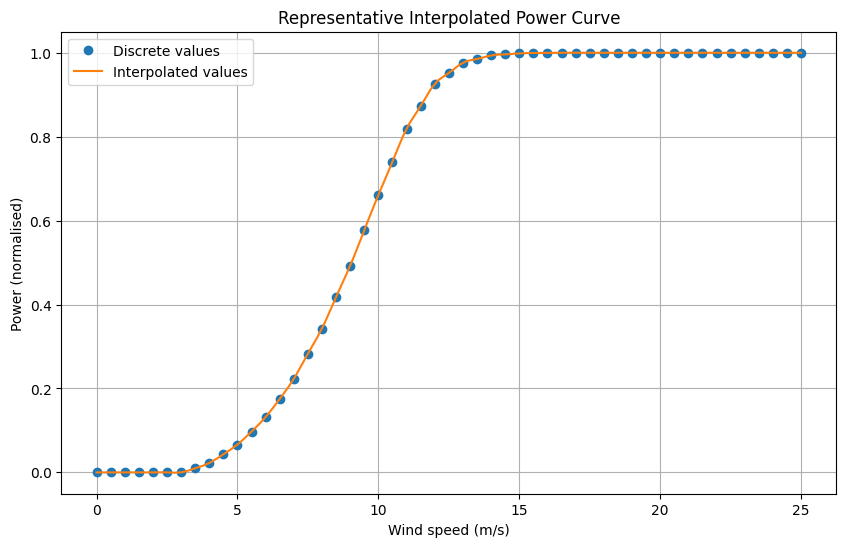

In [165]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# Definiere die Power Curve (Windgeschwindigkeit und Leistung)
wind_speeds = np.arange(0, 25.5, 0.5)  # Windgeschwindigkeiten
power_output = [0]*7 + [35, 80, 155, 238, 350, 474, 630, 802, 1018, 1234, 1504, 1773, 2076, 2379, 2664, 2948, 3141, 3334, 3425, 3515, 3546, 3577, 3586, 3594, 3598, 3599] + [3600]*18  # Leistung
max_cap = 3600
power_output_norm = [x / max_cap for x in power_output]
wind_speed_max = 25

# Erstelle die Interpolationsfunktion
interpolation_function = interp1d(wind_speeds, power_output_norm, kind='cubic', fill_value="extrapolate")

# Beispiel für Interpolation: Bestimme Werte für feinere Windgeschwindigkeiten
fine_wind_speeds = np.linspace(0, 25, 100)  # Feinere Windgeschwindigkeiten
interpolated_power_output = interpolation_function(fine_wind_speeds)

# Plot der diskreten und interpolierten Power Curve
plt.figure(figsize=(10, 6))
plt.plot(wind_speeds, power_output_norm, 'o', label='Discrete values')
plt.plot(fine_wind_speeds, interpolated_power_output, '-', label='Interpolated values')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (normalised)')
plt.title('Representative Interpolated Power Curve')
plt.legend()
plt.grid(True)
plt.show()

Interpolation

In [166]:
# Ensure wind_speeds_data is a numeric array: convert float elements to np.float64 elements
wind_speeds_data = wind_speeds_data.astype(float)

predicted_power_output_1 = interpolation_function(wind_speeds_data) * capacities

<h1>2. Power curves from windpowerlib (for all supported turbine types in feature vector)

c:\Users\alexa\anaconda3\envs\webapp_env_conda\Lib\site-packages\windpowerlib\data.py:103: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(False)


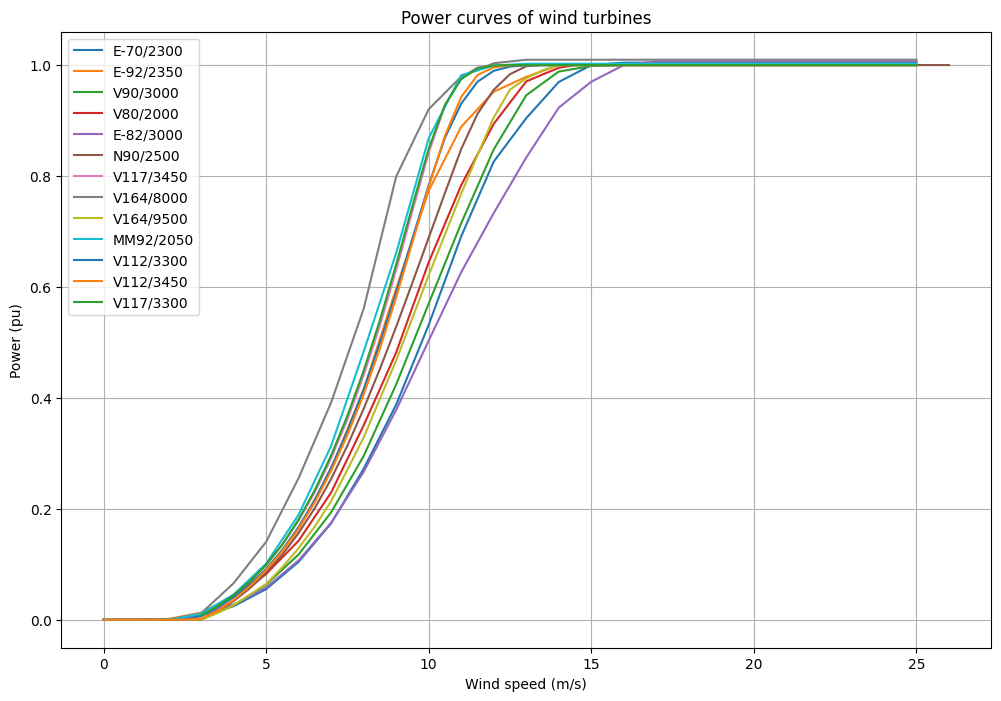

In [ ]:
from windpowerlib import WindTurbine
from windpowerlib import data as wt
import matplotlib.pyplot as plt

# Annahme: turbine_types_set ist bereits definiert und enthält die zu prüfenden Turbinen-Typen
turbine_types_set = set(all_turbine_types)

# Turbinendaten abrufen
turbine_data = wt.get_turbine_types(print_out=False)

# Liste zum Speichern der erstellten WindTurbine-Objekte
wind_turbines = []
wind_turbines_names = []

# Schleife über alle Turbinentypen im Set
for turbine_type in turbine_types_set:
    # Prüfen, ob der Turbinentyp in den Daten existiert
    if turbine_type in turbine_data['turbine_type'].values:
        
        hub_height = 100  # Nabenhöhe irrelevant für power curve
        
        # Definition des WindTurbine-Dictionaries
        turbine_dict = {
            'turbine_type': turbine_type,
            'hub_height': hub_height
        }
        
        # Dynamische Erstellung des WindTurbine-Objekts
        wind_turbine = WindTurbine(**turbine_dict)
        
        # Hinzufügen zur Liste
        wind_turbines.append(wind_turbine)
        wind_turbines_names.append(turbine_type)

# Plot der Power Curves
plt.figure(figsize=(12, 8))
for turbine in wind_turbines:
    if turbine.power_curve is not None:
        plt.plot(turbine.power_curve['wind_speed'], turbine.power_curve['value'] / turbine.nominal_power,
                 label=turbine.turbine_type)

plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (pu)')
plt.title('Power curves of wind turbines')
plt.legend()
plt.grid(True)
plt.show()

Interpolation

In [147]:
from scipy.interpolate import interp1d

# after analysis of plot
default_turbine = next(turbine for turbine in wind_turbines if turbine.turbine_type == "N90/2500")
wind_speed_max = 25

predicted_power_output_2 = []
power_curve_available = []

# Iteration über alle Datenpunkte
for i, (turbine_type, wind_speed, capacity) in enumerate(zip(turbine_types, wind_speeds_data, capacities)):

    if turbine_type in wind_turbines_names:
        power_curve_available.append(True)
        turbine = wind_turbines[wind_turbines_names.index(turbine_type)]
    else:
        power_curve_available.append(False)
        turbine = default_turbine

    # Erstelle eine Interpolationsfunktion für die Power Curve dieser Turbine
    interpolation_function = interp1d(
        turbine.power_curve['wind_speed'],
        turbine.power_curve['value'] / turbine.nominal_power,
        kind='cubic',
        fill_value=0,  # Setze Werte außerhalb des Bereichs auf 0
        bounds_error=False
    )
    
    # Vorhergesagten Wert berechnen
    predicted_power_output_2.append(interpolation_function(wind_speed) * capacity)

predicted_power_output_2 = np.array(predicted_power_output_2)

# Setze vorhergesagte Leistung auf 0 für Windgeschwindigkeiten über wind_speed_max
predicted_power_output_2[wind_speeds_data > wind_speed_max] = 0

<h1>3. One power curve for all, specific power curve only when available

In [168]:
predicted_power_output_3 = np.where(power_curve_available, predicted_power_output_2, predicted_power_output_1)

<h1>4. Only specific power curve, only when available

In [179]:
predicted_power_output_4 = predicted_power_output_2[power_curve_available]
actual_power_output_4 = actual_power_output[power_curve_available]

<h1>5. Exact power curves, scraped from The Wind Power with Power Automate

In [286]:
# Pfad zur Datei
file_path_json = r"C:\Users\alexa\Documents\Webapp\data\power_curves.json"

# Datei mit UTF-16 LE öffnen und lesen
with open(file_path_json, 'r', encoding='utf-16') as file:
    # Zeilenweise die Inhalte als Python-Listen parsen
    data_raw = [eval(line.strip()) for line in file]

# Extrahieren von wind_speed und power
wind_speeds_extracted = [float(item[0]) for item in data_raw]
powers_extracted = [item[1] for item in data_raw]

import pandas as pd 

# Step 2: Load the Excel file
file_path_excel = r"C:\Users\alexa\Documents\Webapp\data\turbine_data.xlsx"
excel_data = pd.read_excel(file_path_excel, sheet_name='Turbine Types')

# Create a mask for non-empty values in the "The Wind Power" column
power_curve_available = excel_data['The Wind Power'].notna()

turbine_types_with_power_curve = np.array(excel_data['Turbine Types'][power_curve_available])

power_curves_individual = []
j = 0
i = 0
while j < len(wind_speeds_extracted):
    if wind_speeds_extracted[j] == 0:
        power_curves_individual.append([[], []])
        i += 1
    power_curves_individual[i-1][0].append(wind_speeds_extracted[j])
    power_curves_individual[i-1][1].append(powers_extracted[j])
    j += 1

predicted_power_output_5 = []

# Iteration über alle Datenpunkte
for i, (turbine_type, wind_speed, capacity) in enumerate(zip(turbine_types, wind_speeds_data, capacities)):

    if turbine_type in turbine_types_with_power_curve:
        power_curve = power_curves_individual[list(turbine_types_with_power_curve).index(turbine_type)]
        interpolation_function = interp1d(
            power_curve[0],
            np.array(power_curve[1]) / max(power_curve[1]),
            kind='cubic',
            fill_value=0,  # Setze Werte außerhalb des Bereichs auf 0
            bounds_error=False
        )
    else:
        interpolation_function = interp1d(wind_speeds, power_output_norm, kind='cubic', fill_value="extrapolate") # wie bei predicted_power_output_1
    
    # Vorhergesagten Wert berechnen
    predicted_power_output_5.append(interpolation_function(wind_speed) * capacity)

predicted_power_output_5 = np.array(predicted_power_output_5)

0
1
2
3
4
5
6
8
10
11
13
14
15
16
17
19
20
21
22
23
25
26
27
28
29
30
31
33
34
35
36
37
38
40
41
42
43
44
46
48
50
51
53
54
55
57
58
59
60
61
62
63
64
65
66
68
69
70
71
72
73
75
76
77
78
79
81
82
85
86
87
90
91
92
93
94
96
97
98
100
101
102
104
105
107
108
109
110
111
112
113
114
117
118
120
121
122
123
124
125
128
130
131
133
134
135
136
137
138
140
141
142
143
144
145
146
147
148
149
151
152
153
154
155
156
157
159
160
161
163
164
165
167
168
169
170
171
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
193
194
195
196
197
199
200
201
202
203
204
206
207
209
210
211
212
213
214
215
216
217
218
219
221
222
223
224
225
226
227
228
229
231
232
233
234
235
236
237
238
239
241
242
243
244
245
247
248
249
251
252
253
255
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319

<h1>6. Results

In [287]:
predicted_power_output = predicted_power_output_5
actual_power_output = actual_power_output

In [288]:
import torch

# Ensure the arrays are of type float
predicted_power_output = predicted_power_output.astype(float)
actual_power_output = actual_power_output.astype(float)

predicted_torch = torch.tensor(predicted_power_output, dtype=torch.float32)
actual_torch = torch.tensor(actual_power_output, dtype=torch.float32)

# Berechne den Huber Loss
huber_loss_fn = torch.nn.HuberLoss()
huber_loss_value = huber_loss_fn(predicted_torch, actual_torch).item()
print(f"Huber Loss: {huber_loss_value:.2f}")

# Berechne den MAE Loss
mae_loss_fn = torch.nn.L1Loss()  # L1 Loss entspricht MAE
mae_loss_value = mae_loss_fn(predicted_torch, actual_torch).item()
print(f"Mean Absolute Error (MAE): {mae_loss_value:.2f} MW")

# Berechne den MSE Loss
mse_loss_fn = torch.nn.MSELoss()
mse_loss_value = mse_loss_fn(predicted_torch, actual_torch).item()
print(f"Mean Squared Error (MSE): {mse_loss_value:.2f} MW²")

Huber Loss: 26.02
Mean Absolute Error (MAE): 26.48 MW
Mean Squared Error (MSE): 2752.38 MW²


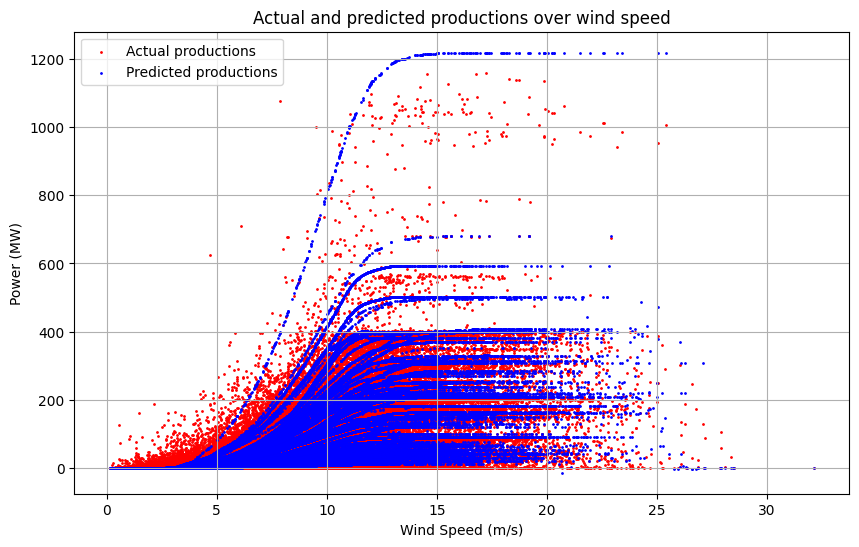

In [289]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(wind_speeds_data, actual_power_output, color='red', s=1, label='Actual productions')
plt.scatter(wind_speeds_data, predicted_power_output, color='blue', s=1, label='Predicted productions')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (MW)')
plt.title('Actual and predicted productions over wind speed')
plt.legend()
plt.grid(True)
plt.show()

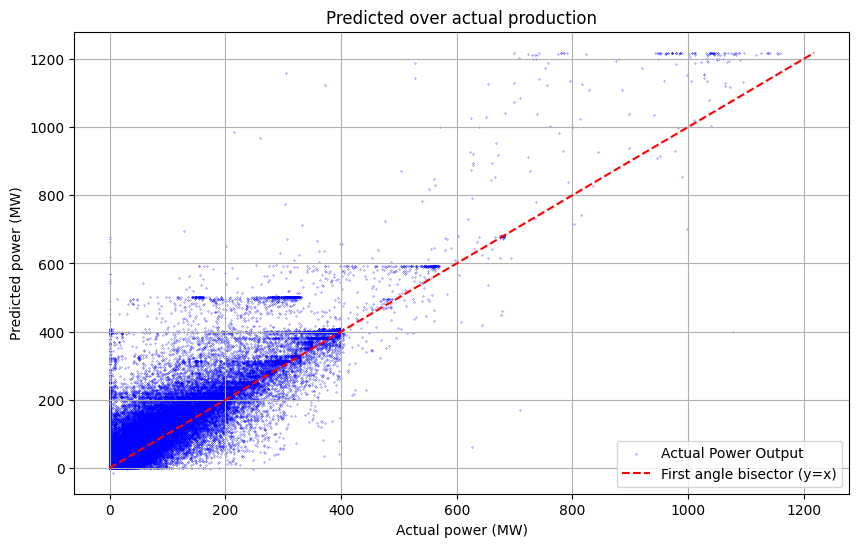

In [290]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(actual_power_output, predicted_power_output, color='blue', s=0.05, label='Actual Power Output')
max_capacity = max(capacities.max(), actual_power_output.max())
plt.plot([0, max_capacity], [0, max_capacity], color='red', linestyle='--', label='First angle bisector (y=x)')
plt.xlabel('Actual power (MW)')
plt.ylabel('Predicted power (MW)')
plt.title('Predicted over actual production')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\alexa\AppData\Local\Temp\ipykernel_7420\4000434538.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


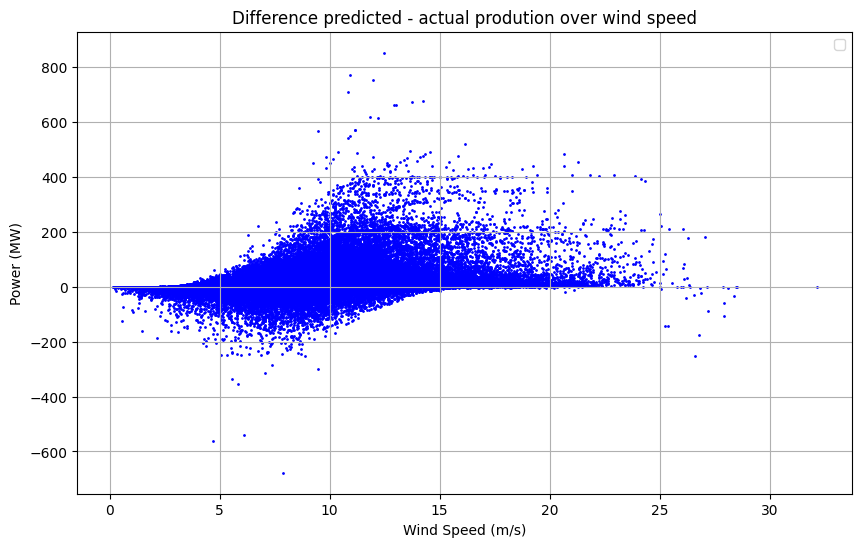

In [291]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(wind_speeds_data, predicted_power_output-actual_power_output, color='blue', s=1)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (MW)')
plt.title('Difference predicted - actual prodution over wind speed')
plt.legend()
plt.grid(True)
plt.show()

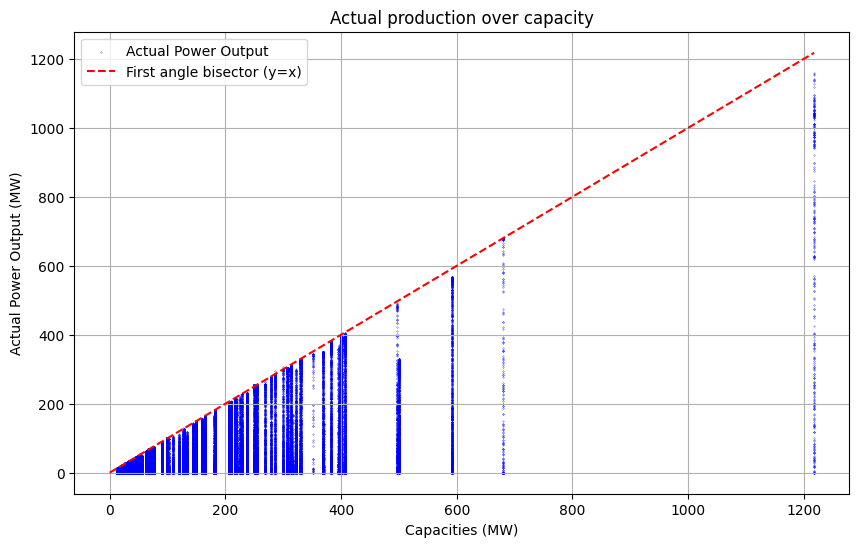

In [292]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(capacities, actual_power_output, color='blue', s=0.05, label='Actual Power Output')
max_capacity = max(capacities.max(), actual_power_output.max())
plt.plot([0, max_capacity], [0, max_capacity], color='red', linestyle='--', label='First angle bisector (y=x)')
plt.xlabel('Capacities (MW)')
plt.ylabel('Actual Power Output (MW)')
plt.title('Actual production over capacity')
plt.legend()
plt.grid(True)
plt.show()